---

title: "显著水平、统计功效、一类错误、二类错误"
date: 2024-11-14
author: 郝鸿涛
slug: power-alpha-errors
draft: false
toc: true
tags: 统计

---

>科学研究证明，火星人智商的方差是 $36$，我们不知道其平均值 ($\mu$)。为了知道 $\mu$，科学家随机抽取了 $16$ 名火星人，测量他们的智商。科学家的假设是 $H_0: \mu = 100$，$H_A: \mu \ne 100$。

如果把这 16 名火星人的平均智商记为 $\bar{X}$，那根据中心极限定理的知识，我们知道其分布为：

In [142]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as stats 

In [143]:
mu0 = 100 

sigma = np.sqrt(250)
n = 16 
# standard error
se = sigma/np.sqrt(n)

xs = np.linspace(mu0 - 4*se, mu0 + 4*se, 100)
y = stats.norm.pdf(xs, mu0, se)


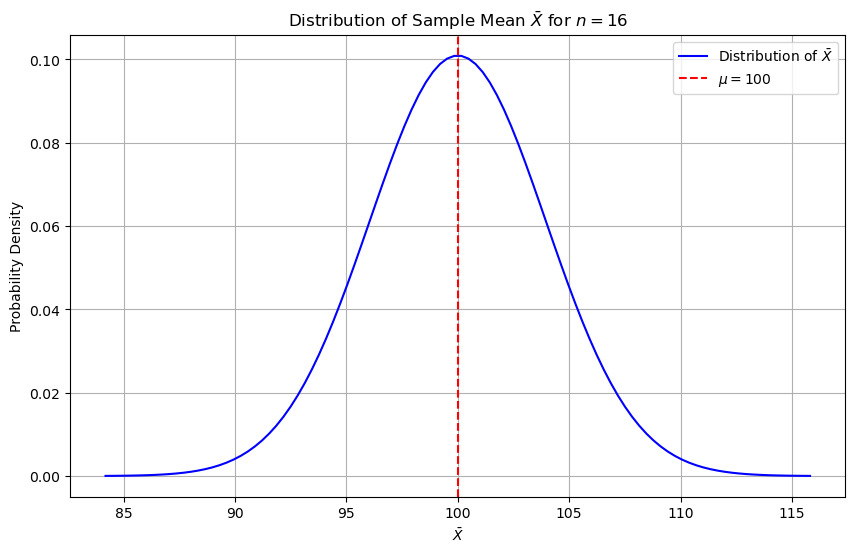

In [144]:
#| code-fold:true

plt.figure(figsize=(10,6))
plt.plot(
    xs, y, 
    label=r'Distribution of $\bar{X}$', color='blue')
plt.title(r'Distribution of Sample Mean $\bar{X}$ for $n = 16$')
plt.xlabel(r'$\bar{X}$')
plt.ylabel('Probability Density')
plt.axvline(
    mu0, color='red', 
    linestyle='--', label=r'$\mu = 100$')
plt.legend()
plt.grid(True)
plt.show()

## 显著水平、一类错误

如果 $\alpha = 0.05$，那么 $\bar{X}$ 为多少时，我们会拒绝 $H_0$？

In [145]:
alpha = 0.05

# norm.ppf() 相当于 R 中的 qnorm() 
# ppf: percent point function; inverse of cdf
lower_bound = stats.norm.ppf(alpha/2, loc=mu0, scale = se)
upper_bound = stats.norm.ppf(1-alpha/2, loc = mu0, scale = se)
lower_bound, upper_bound

(92.25256209619297, 107.74743790380703)

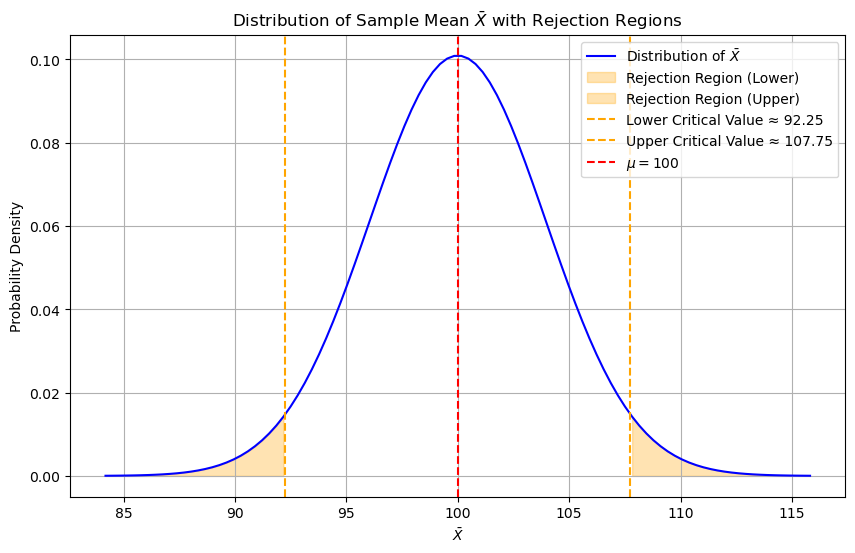

In [146]:
#| code-fold:true

plt.figure(figsize=(10, 6))
plt.plot(xs, y, label=r'Distribution of $\bar{X}$', color='blue')
plt.fill_between(xs, y, where=(xs <= lower_bound), color='orange',
                 alpha=0.3, label='Rejection Region (Lower)')
plt.fill_between(xs, y, where=(xs >= upper_bound), color='orange',
                 alpha=0.3, label='Rejection Region (Upper)')
plt.axvline(lower_bound, color='orange', linestyle='--',
            label=f'Lower Critical Value ≈ {lower_bound:.2f}')
plt.axvline(upper_bound, color='orange', linestyle='--',
            label=f'Upper Critical Value ≈ {upper_bound:.2f}')
plt.axvline(mu0, color='red', linestyle='--', label=r'$\mu = 100$')
plt.title(r'Distribution of Sample Mean $\bar{X}$ with Rejection Regions')
plt.xlabel(r'$\bar{X}$')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

上图中的黄色区域被称为「拒绝域」(Rejection Region)。

$\alpha$ 被称为显著水平，或者叫做「一类错误」(Type one error)。它所表达的意思是，本来 $H_0$ 是真相，但我们抽到的数据 (黄色区域中的 $\bar{X}$ 值) 显示 $H_0$ 为真的话不太可能出现这样的 $\bar{X}$，所以我们（错误地）拒绝。

## 统计功效和二类错误

我们来看另外一种情况：$H_0$ 不成立，$H_A：\mu_{A} = 105$ 为真。

$H_A$ 如果成立，$\bar{X}$ 的分布是：

In [147]:
mua = 105

xs = np.linspace(mua - 4*se, mua + 4*se, 100)
y = stats.norm.pdf(xs, mua, se)

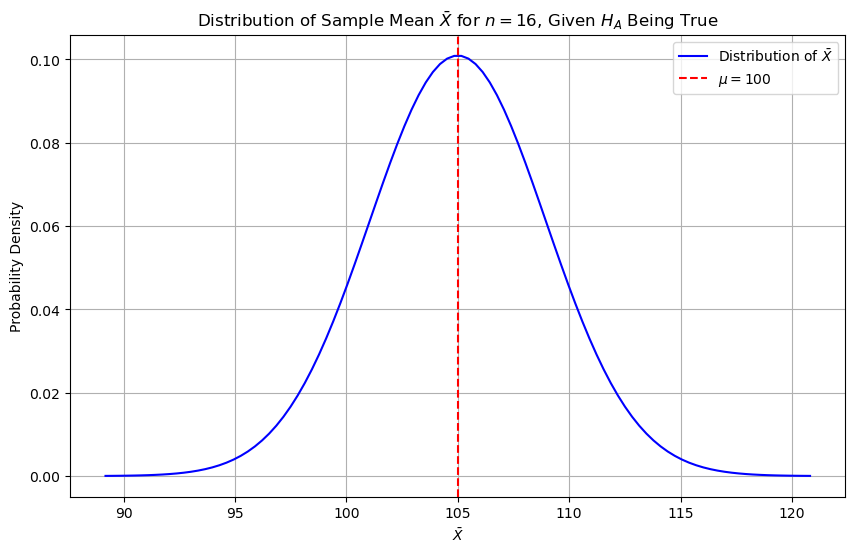

In [148]:
#| code-fold:true

plt.figure(figsize=(10,6))
plt.plot(
    xs, y, 
    label=r'Distribution of $\bar{X}$', color='blue')
plt.title(r'Distribution of Sample Mean $\bar{X}$ for $n = 16$, Given $H_A$ Being True')
plt.xlabel(r'$\bar{X}$')
plt.ylabel('Probability Density')
plt.axvline(
    mua, color='red', 
    linestyle='--', label=r'$\mu = 100$')
plt.legend()
plt.grid(True)
plt.show()

那当 $H_A$ 成立时，$\bar{X}$ 落在上图黄色区域，也就是拒绝域，的概率是多大？

In [149]:
lower_region_area = stats.norm.cdf(lower_bound, loc=mua, scale = se)
upper_region_area = 1-stats.norm.cdf(upper_bound, loc=mua, scale = se)
lower_region_area + upper_region_area

0.24414120703414016

我们看到概率大概是 $91.5\%$，这被称为「统计功效」(Power)，也就是说当 $H_0$ 为假、$H_A$ 为真时，我们拒绝 $H_0$ 的概率。

那当 $H_0$ 为假、$H_A$ 为真时，我们也可能会接受 $H_0$，这种情况下我们犯了「二类错误」(Type Two Error)。很明显，Type Two Error = 1 - Power。因为 $H_0$ 为假、$H_A$ 为真时，我们要么接受 $H_0$，要么拒绝，不可能有第三种情况。

## 统计功效曲线

我们上面算了 $\mu_A = 105$ 的情况，但还可能有别的情况，我们可以都算出来，然后画出所有对应的统计功效。

首先，我们要计算统计功效：

In [150]:
def calc_power(mu0, mua, sigma2, n, alpha):
    """
    Inputs:
        - mu0: mu when h0 is true
        - mua: mu when ha is true 
        - sigma2: population variance
        - n: sample size 
        - alpha: significance level; type one error
    Output:
        - power: a float (prob of rejecting H0 when HA is true)
    """
    # population sd
    sigma = np.sqrt(sigma2)
    # standard error; sd for sampling distribution 
    se = sigma/np.sqrt(n)

    # rejection region based on H0
    lower_bound = stats.norm.ppf(alpha/2, loc=mu0, scale = se)
    upper_bound = stats.norm.ppf(1-alpha/2, loc = mu0, scale = se) 

    # calculate power under HA
    lower_region_area = stats.norm.cdf(lower_bound, loc=mua, scale = se)
    upper_region_area = 1-stats.norm.cdf(upper_bound, loc=mua, scale = se)
    power = lower_region_area + upper_region_area   
    
    return power
    

In [151]:
calc_power(mu0 = 100, mua = 105, sigma2 = 36, n = 16, alpha = 0.05)

0.9151812833018267

我们把 95 到 120 都算一遍：

In [152]:
start = 95
end = 120
mua_array = np.arange(start, end + 1, 1)
powers = [
    calc_power(
        mu0 = 100, 
        mua = x, 
        sigma2 = 36, 
        n = 16, 
        alpha = 0.05
        ) for x in mua_array
    ]

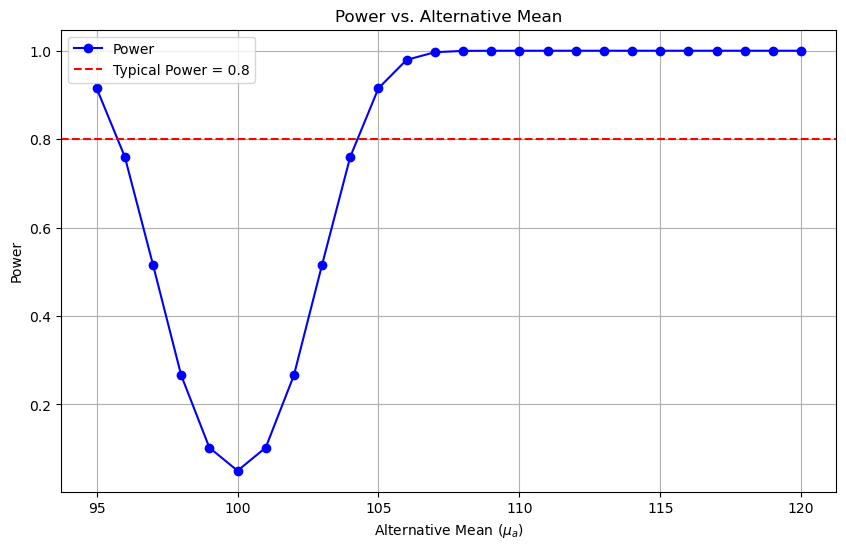

In [153]:
#| code-fold:true

plt.figure(figsize=(10, 6))

# Use a line plot for smoother visualization
plt.plot(mua_array, powers, marker='o', linestyle='-', color='b', label='Power')

# Add labels and title
plt.xlabel(r'Alternative Mean ($\mu_a$)')
plt.ylabel('Power')
plt.title('Power vs. Alternative Mean')

# Add a horizontal line to indicate a typical power threshold (e.g., 0.8)
plt.axhline(0.8, color='red', linestyle='--', label='Typical Power = 0.8')

# Add a legend and grid
plt.legend()
plt.grid(True)

plt.show()


## 交互图表

<div>
    <div id="sigma2"></div>
    <div id="n"></div>
    <div id="alpha"></div>
    <div id="powerChart"></div>
</div>

<style>
 #powers,
 #sigma2,
 #n,
 #alpha {
        margin-bottom: 10px;
      }

 input[type="range"] {
      width: 600px; /* Adjust this width as needed */
  }
</style>


<script type="module">
      import {Runtime, Inspector} from "https://cdn.jsdelivr.net/npm/@observablehq/runtime@4/dist/runtime.js";
      import notebook from "https://api.observablehq.com/d/83a5fe422e629db2.js?v=3";

      function render(_node, value) {
        if (!(value instanceof Element)) {
          const el = document.createElement("span");
          el.innerHTML = value;
          value = el;
        }
        if (_node.firstChild !== value) {
          if (_node.firstChild) {
            while (_node.lastChild !== _node.firstChild) _node.removeChild(_node.lastChild);
            _node.replaceChild(value, _node.firstChild);
          } else {
            _node.appendChild(value);
          }
        }
      }
      
      const renders = {
        "viewof sigma2": "#sigma2",
        "viewof n": '#n',
        "viewof alpha": '#alpha',
        "powerChart": '#powerChart'
      }

      
      const runtime = new Runtime();
      const main = runtime.module(notebook, name => {
        const selector = renders[name];
        if (selector) {
          return {fulfilled: (value) => render(document.querySelector(selector), value)}
        } else {
          return true;
        }
      });
      
    </script>